## Kaggle Reuse Experiment
In this notebook, we make the plot in Figure 8 of Section 6.4.

Experiment result is located here:

'./experiment_results/remote/reuse/kaggle_home_credit/cloud-41/2019-10-19/09-49.csv'


In [19]:
# numpy and pandas for data manipulation
import sys
# Suppress warnings
import warnings
import seaborn as sns
import matplotlib as plt
import networkx as nx
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
import os
import matplotlib2tikz
plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_style({'grid.color': '.5'})
sns.set_context("paper", font_scale=2, rc={"lines.markersize": 15})
plt.rc('hatch', color='white', linewidth=1)
plt.rcParams.update({
    "font.family": "serif",
     "font.serif": [] ,
      "font.sans-serif": ["Linux Biolinum"]  })

warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
ROOT_RESULT_FOLDER = '/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/experiment_results/remote'


SYSTEM_COLOR = sns.color_palette()[0]
ALL_MAT_COLOR = sns.color_palette()[1]
ALL_COMPUTE_COLOR = sns.color_palette()[2]
BOTTOMUP_COLOR = sns.color_palette()[3]

WRITE_DIRECTORY_ROOT = \
'/Users/bede01/Documents/work/phd-papers/ml-workload-optimization/papers/images/experiment-results'

output_directory = WRITE_DIRECTORY_ROOT + '/kaggle_home_credit/reuse'
def create_folder(path):
    if not os.path.exists(os.path.dirname(path)):
        try:
            os.makedirs(os.path.dirname(path))
        except OSError as exc:  # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise

In [20]:
TICK_LABEL_SIZE = 34
AXIS_FONT = 40

In [21]:
result_folder = ROOT_RESULT_FOLDER + '/reuse/kaggle_home_credit'
#result_file = result_folder + '/cloud-41/2019-10-13/23-13.csv'
result_file = result_folder + '/cloud-41/2019-10-19/09-49.csv'

In [22]:
HEADERS = [
    'timestamp', 'exp_id', 'repo', 'workload', 'mat_type','reuse_type', 'budget','run_time'
]
execution_order = {
    'start_here_a_gentle_introduction': 1,
    'introduction_to_manual_feature_engineering': 2,
    'introduction_to_manual_feature_engineering_p2': 3,
    'fork_cridata_start_here_a_gentle_introduction': 4,
    'fork_taozhongxiao_start_here_a_gentle_introduction': 5,
    'fork_introduction_to_manual_feature_engineering': 6,
    'fork_introduction_to_manual_feature_engineering_p2': 7,
    'fork_join_start_here_intro': 8
}
reuse_map = {'linear':'LN','all_mat':'ALL_M', 'all_compute':'ALL_C', 'bottomup':'BU'}
reuse_result = pd.read_csv(result_file, header=None, names=HEADERS)
reuse_result['workload_order'] = reuse_result['workload'].replace(execution_order)
reuse_result['reuse_type'] = reuse_result['reuse_type'].replace(reuse_map)
reuse_result = reuse_result[reuse_result.reuse_type != 'BU']
reuse_result['cumulative_run_time'] = reuse_result.groupby(['exp_id', 'reuse_type'])['run_time'].apply(lambda x: x.cumsum())

In [23]:
def plot_executions_times(df, loc=None):
    plt.figure(figsize=(8,4))
    plot = sns.lineplot(
        data=df,
        x='workload_order',
        y='cumulative_run_time',
        hue='reuse_type',
        style='reuse_type',
        markers={
            'LN': "o",
            'ALL_M': "^",
            'ALL_C': 'v'
        },
        lw=3,
        ci='sd',
        hue_order=['LN', 'ALL_M', 'ALL_C'],
       # style_order = ['baseline', 'optimized'],
        dashes={
            'LN': (1, 0),
            'ALL_M': (3, 1),
            'ALL_C': (1, 1)
        },
        palette={
            'LN': SYSTEM_COLOR,
            'ALL_M': ALL_MAT_COLOR,
            'ALL_C': ALL_COMPUTE_COLOR
        },
        legend='brief')
    lg = plt.legend(
        loc='upper center',
        handlelength=1.5,
        handletextpad=0.1,
        fontsize=TICK_LABEL_SIZE,
        ncol=3,
        columnspacing=0.5,
        bbox_to_anchor=(0.55, 1.2))
    handles = lg.legendHandles
    labels = ['LN', 'ALL_M', 'ALL_C']
    del handles[0]
    from matplotlib.lines import Line2D
    handles[0] = Line2D([0], [1],
                        color=SYSTEM_COLOR,
                        linewidth=4,
                        dashes=(1, 0),
                        marker="o")
    handles[1] = Line2D([0], [1],
                        color=ALL_MAT_COLOR,
                        linewidth=4,
                        dashes=(3, 1),
                        marker="^")
    handles[2] = Line2D([0], [1],
                        color=ALL_COMPUTE_COLOR,
                        linewidth=4,
                        dashes=(1, 1),
                        marker="v")
    legend = plt.legend(
        handles,
        labels,
        loc='upper center',
        handlelength=1.5,
        handletextpad=0.1,
        fontsize=TICK_LABEL_SIZE,
        numpoints=1,
        ncol=3,
        columnspacing=0.2,
        bbox_to_anchor=(0.5, 1.27))

    plt.tick_params(labelsize=TICK_LABEL_SIZE)
    for line in legend.get_lines():
        line.set_linewidth(4.0)
    plot.set_xlabel('Workload', fontsize=AXIS_FONT)
    plot.set_ylabel('Cumulative \nRun Time (s)', fontsize=AXIS_FONT)
    #plot.set_xlim((1,2))
    plot.set_ylim((0,2200))
    plot.set_yticks([0, 500, 1000, 1500, 2000])
    plot.set_xticks(range(1,9))
    plot.set_xticklabels(range(1,9))
    plot.yaxis.set_major_formatter(ticker.EngFormatter(sep=''))
    #plt.tight_layout()
    if loc is not None:
        plt.savefig(loc, bbox_inches ='tight')

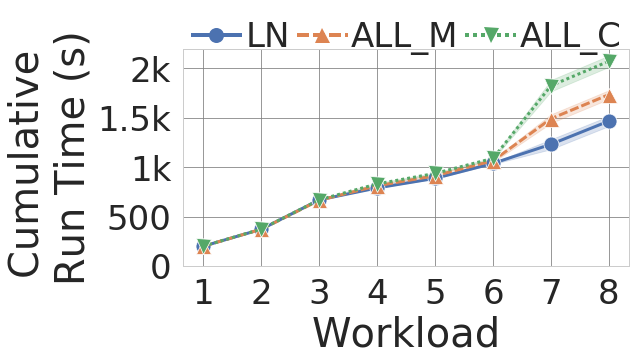

In [24]:
df = reuse_result[reuse_result.mat_type == 'simple']
#plot_executions_times(df)
plot_executions_times(df, output_directory+'/simple-mat.pgf')

In [26]:
df.groupby(['workload_order','reuse_type']).mean()

budget    run_time  cumulative_run_time
workload_order reuse_type                                             
1              ALL_C       16777216.0  200.963620           200.963620
               ALL_M       16777216.0  200.001384           200.001384
               LN          16777216.0  200.209015           200.209015
2              ALL_C       16777216.0  171.927725           372.891345
               ALL_M       16777216.0  171.530838           371.532222
               LN          16777216.0  171.577346           371.786361
3              ALL_C       16777216.0  296.934686           669.826031
               ALL_M       16777216.0  293.205066           664.737288
               LN          16777216.0  297.352466           669.138827
4              ALL_C       16777216.0  161.040558           830.866589
               ALL_M       16777216.0  147.049424           811.786712
               LN          16777216.0  120.869994           790.008821
5              ALL_C       16777216.0  105.830294           936.696883
               ALL_M       16777216.0  101.646007           913.432719
               LN          16777216.0   97.044989           887.053810
6              ALL_C       16777216.0  153.082213          1089.779097
               ALL_M       16777216.0  152.487945          1065.920664
               LN          16777216.0  151.449520          1038.503330
7              ALL_C       16777216.0  735.314044          1825.093141
               ALL_M       16777216.0  425.114777          1491.035441
               LN          16777216.0  193.476582          1231.979912
8              ALL_C       16777216.0  247.440697          2072.533838
               ALL_M       16777216.0  243.552060          1734.587501
               LN          16777216.0  235.241056          1467.220968

In [31]:
1734.587501 - 1467.220968

267.3665329999999

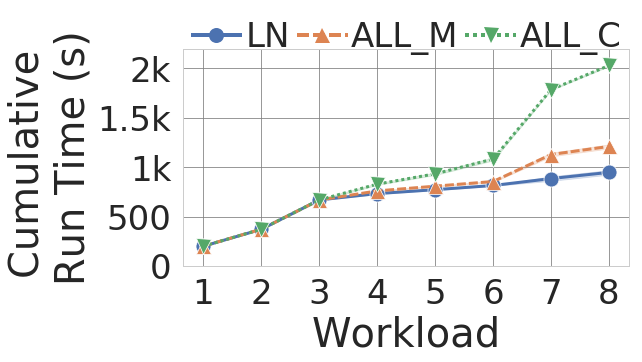

In [27]:
df = reuse_result[reuse_result.mat_type == 'storage_aware']
#plot_executions_times(df)
plot_executions_times(df, output_directory+'/storage-aware-mat.pgf')

In [28]:
df.groupby(['workload_order','reuse_type']).mean()

budget    run_time  cumulative_run_time
workload_order reuse_type                                             
1              ALL_C       16777216.0  200.195100           200.195100
               ALL_M       16777216.0  200.505934           200.505934
               LN          16777216.0  200.043097           200.043097
2              ALL_C       16777216.0  171.363564           371.558663
               ALL_M       16777216.0  171.442504           371.948438
               LN          16777216.0  170.945364           370.988461
3              ALL_C       16777216.0  297.002178           668.560841
               ALL_M       16777216.0  295.175590           667.124028
               LN          16777216.0  297.538360           668.526821
4              ALL_C       16777216.0  159.820241           828.381083
               ALL_M       16777216.0   92.603771           759.727799
               LN          16777216.0   64.013486           732.540307
5              ALL_C       16777216.0  104.211678           932.592761
               ALL_M       16777216.0   48.014830           807.742628
               LN          16777216.0   39.730192           772.270498
6              ALL_C       16777216.0  149.929599          1082.522359
               ALL_M       16777216.0   47.057373           854.800001
               LN          16777216.0   42.355592           814.626090
7              ALL_C       16777216.0  702.786721          1785.309080
               ALL_M       16777216.0  273.223348          1128.023349
               LN          16777216.0   69.947720           884.573810
8              ALL_C       16777216.0  243.301075          2028.610155
               ALL_M       16777216.0   81.816714          1209.840063
               LN          16777216.0   62.891106           947.464916